In [26]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.special import boxcox1p
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
import math
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [27]:
features = pd.read_csv("features.csv")
sales = pd.read_csv("Sales.csv")
stores = pd.read_csv("stores.csv")
final = pd.read_csv('final_predictions.csv')
# print(features)
# print(sales)
# print(stores)

In [28]:
#Data Cleaning and Exploratory Analysis
merge1 = sales.merge(features, on=['Store', 'Date','IsHoliday'], how='inner').merge(stores, on=['Store'], how='inner')

print(merge1)

        Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  \
0           1     1  2010-02-05      24924.50      False        42.31   
1           1     2  2010-02-05      50605.27      False        42.31   
2           1     3  2010-02-05      13740.12      False        42.31   
3           1     4  2010-02-05      39954.04      False        42.31   
4           1     5  2010-02-05      32229.38      False        42.31   
...       ...   ...         ...           ...        ...          ...   
421565     45    93  2012-10-26       2487.80      False        58.85   
421566     45    94  2012-10-26       5203.31      False        58.85   
421567     45    95  2012-10-26      56017.47      False        58.85   
421568     45    97  2012-10-26       6817.48      False        58.85   
421569     45    98  2012-10-26       1076.80      False        58.85   

        Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0            2.572        NaN        NaN      

In [29]:
# Types of data
pd.DataFrame(merge1.dtypes, columns=['Type'])

,Type
Store,int64
Dept,int64
Date,object
Weekly_Sales,float64
IsHoliday,bool
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64


In [30]:
#checking full Data for null columns

null_columns = (merge1.isnull().sum(axis = 0)/len(merge1)).sort_values(ascending=False).index
null_data = pd.concat([
    merge1.isnull().sum(axis = 0),
    (merge1.isnull().sum(axis = 0)/len(merge1)).sort_values(ascending=False),
    merge1.loc[:, merge1.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]

null_data
#here we find that each of the mark downs has more than 60% null values, so we are going to drop these columns 

,# null,% null,type
MarkDown2,310322,0.736110,float64
MarkDown4,286603,0.679847,float64
MarkDown3,284479,0.674808,float64
MarkDown1,270889,0.642572,float64
MarkDown5,270138,0.640790,float64


In [31]:
merge2 = merge1.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])


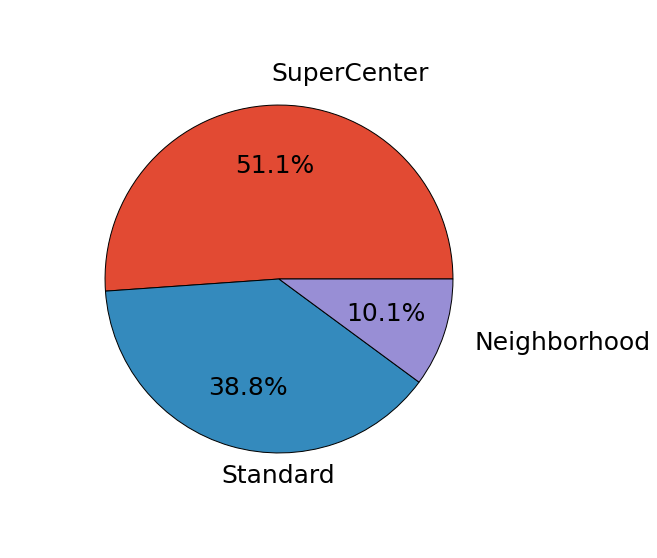

In [32]:
#Finding types of the 45 Stores 
count_type = merge1['Type'].value_counts(normalize=True)
#A    0.511132  22 SuperCenters
# B    0.387824  17 Standard
# C    0.101044  6 Neighborhood


plt.style.use('ggplot')

labels=['SuperCenter','Standard','Neighborhood']

sizes=merge1.describe()['Size'].round(1)

sizes=[0.511132,0.387824,0.101044]

fig, axes = plt.subplots(1,1, figsize=(10,10))

wprops={'edgecolor':'black',
      'linewidth':1}

tprops = {'fontsize':25}

axes.pie(sizes,
        labels=labels,
        explode=(0.0,0,0),
        autopct='%1.1f%%',
        pctdistance=0.65,
        labeldistance=1.18,
        wedgeprops=wprops,
        textprops=tprops,
        radius=0.8,
        center=(0.5,0.5))

plt.show()

In [33]:
# # Holiday Analysis
# #Sales change by overall weekly avg. during holidays and not during holidays
# sales_stores = sales.merge(stores, on=['Store'], how='inner')

# holiday = sales_stores['Weekly_Sales'].loc[sales_stores['IsHoliday']== True] 

# non_holiday = sales_stores['Weekly_Sales'].loc[sales_stores['IsHoliday']== False] 

# # Finding means
# h = holiday.astype(int)
# nh = non_holiday.astype(int)
# h_avg = h.mean().round(2)
# nh_avg = nh.mean().round(2)
# # H=17035.35 NH=15900.98, this means there was a 7.13% increase on avg when there was a holiday

# sns.barplot(x='IsHoliday', y='Weekly_Sales', data=sales_stores)



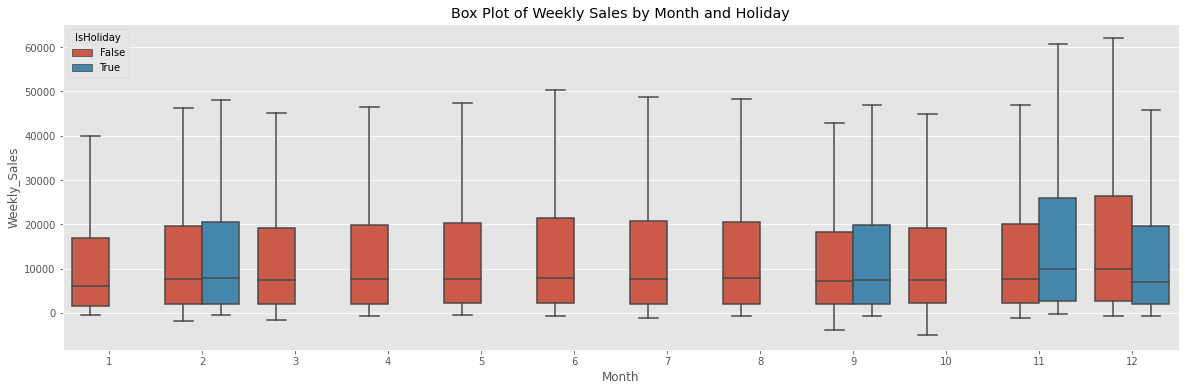

In [34]:
#Aggragating Data by Month and year to find how Holidays effect revenue

monthly = merge2.iloc[: , :].copy()

monthly['Date'] = pd.to_datetime(monthly['Date'], dayfirst=True)
monthly['Week'] = monthly['Date'].dt.isocalendar().week
monthly['Month'] = monthly['Date'].dt.month
monthly['Year'] = monthly['Date'].dt.year
data_14 = pd.concat([monthly['Month'], monthly['Weekly_Sales'], monthly['IsHoliday']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Month and Holiday')
fig = sns.boxplot(x='Month', y='Weekly_Sales', data=data_14, showfliers=False, hue='IsHoliday')

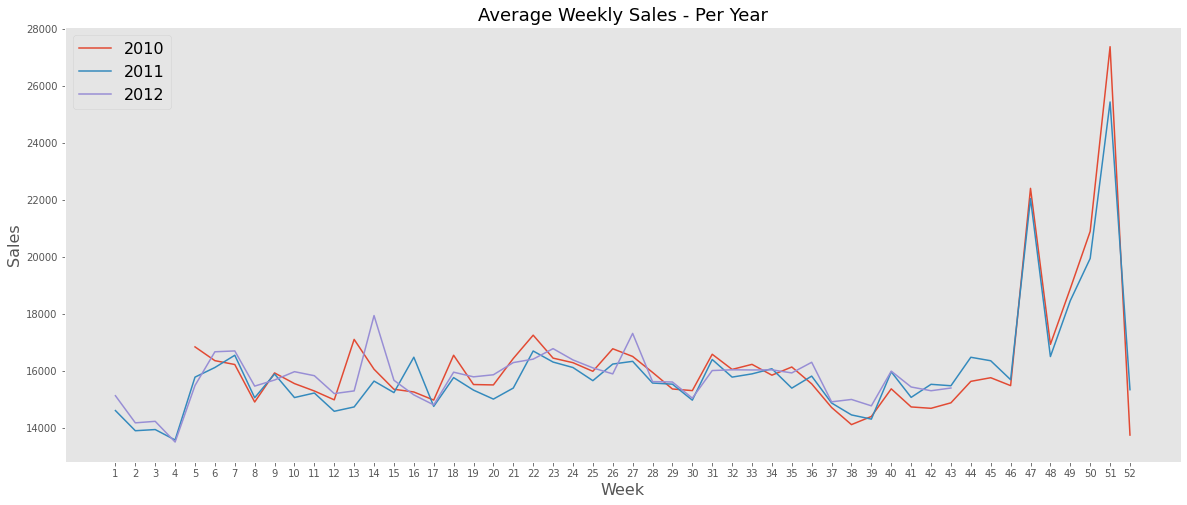

In [35]:
#


weekly_sales_2010 = monthly[monthly.Year==2010]['Weekly_Sales'].groupby(monthly['Week']).mean()
weekly_sales_2011 = monthly[monthly.Year==2011]['Weekly_Sales'].groupby(monthly['Week']).mean()
weekly_sales_2012 = monthly[monthly.Year==2012]['Weekly_Sales'].groupby(monthly['Week']).mean()

plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

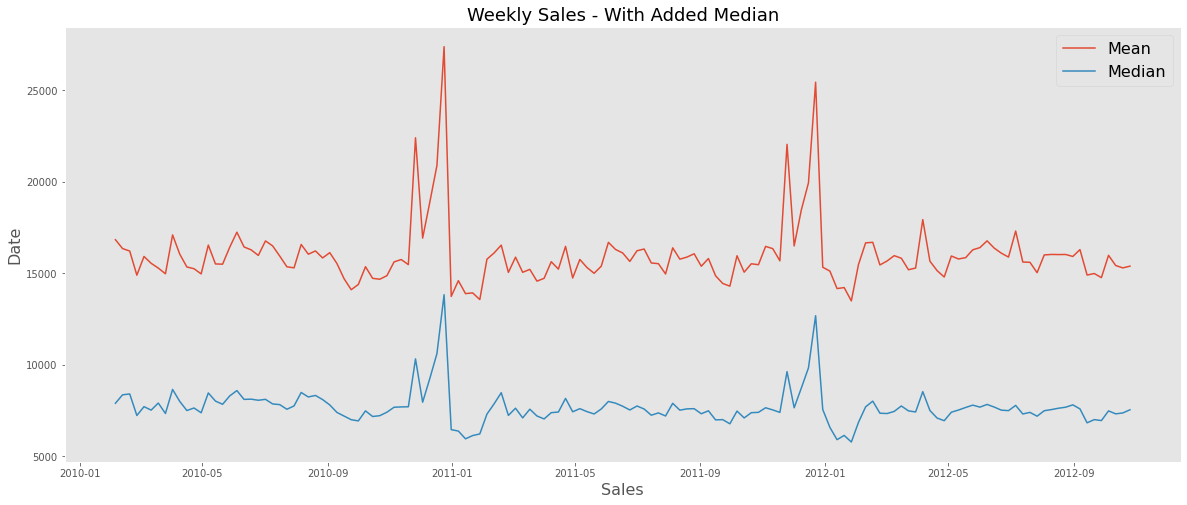

In [36]:


monthly.loc[(monthly.Year==2010) & (monthly.Week==13), 'IsHoliday'] = True
monthly.loc[(monthly.Year==2011) & (monthly.Week==16), 'IsHoliday'] = True
monthly.loc[(monthly.Year==2012) & (monthly.Week==14), 'IsHoliday'] = True

weekly_sales_mean = monthly['Weekly_Sales'].groupby(monthly['Date']).mean()
weekly_sales_median = monthly['Weekly_Sales'].groupby(monthly['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - With Added Median', fontsize=18)
plt.xlabel('Sales', fontsize=16)
plt.ylabel('Date', fontsize=16)
plt.show()


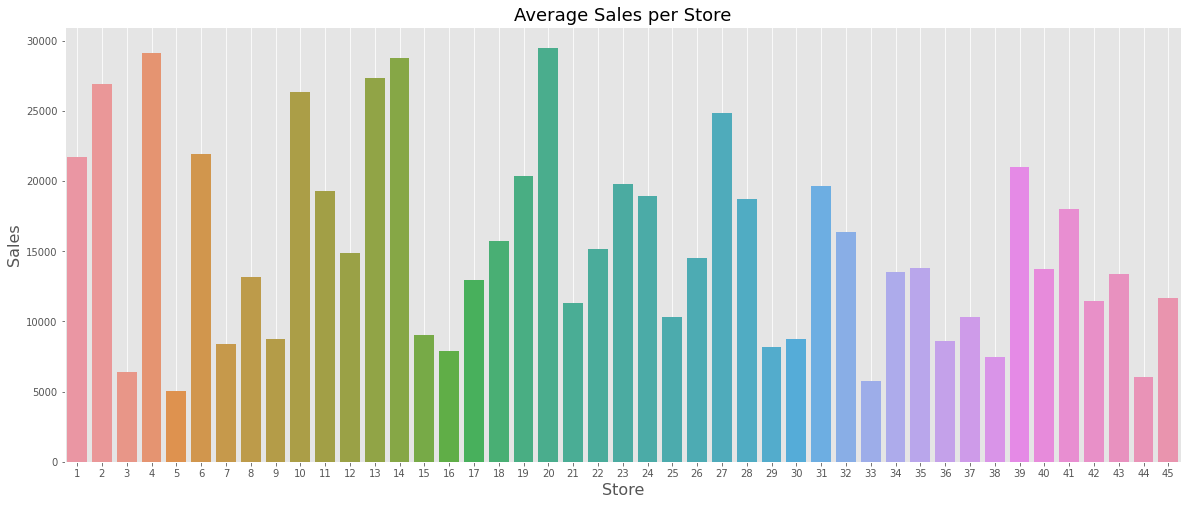

In [37]:
weekly_sales = monthly['Weekly_Sales'].groupby(monthly['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values)
plt.grid()
plt.title('Average Sales per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

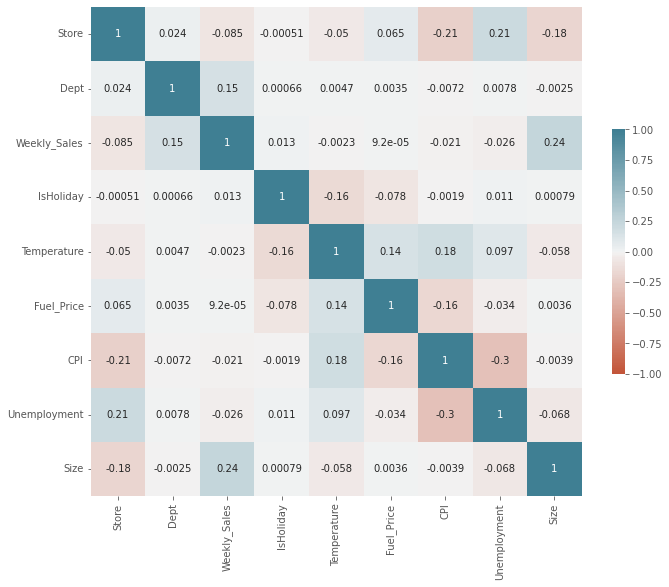

In [38]:
data = merge2.fillna(0)

data.isna().sum()

data = data[data['Weekly_Sales'] >= 0]

f, ax = plt.subplots(figsize=(11, 9))
corr_matrix = data.corr()

sns.heatmap(corr_matrix,
            vmin=-1, 
            vmax=1, 
            center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            cbar_kws={"shrink": .5},
            annot=True)
plt.show()

In [39]:

def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

monthly.Type = [ ord(x) - 64 for x in monthly.Type ]

In [40]:

def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [41]:
def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [42]:
def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [43]:
X_train = monthly[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = monthly['Weekly_Sales']

In [44]:
n_estimators = [56, 58, 60]
max_depth = [25, 27, 30]

random_forest(n_estimators, max_depth)

k: 1 , n_estimators: 56 , max_depth: 25
k: 2 , n_estimators: 56 , max_depth: 25
k: 3 , n_estimators: 56 , max_depth: 25
k: 4 , n_estimators: 56 , max_depth: 25
WMAE: 1533.17
k: 1 , n_estimators: 56 , max_depth: 27
k: 2 , n_estimators: 56 , max_depth: 27
k: 3 , n_estimators: 56 , max_depth: 27
k: 4 , n_estimators: 56 , max_depth: 27
WMAE: 1528.1875
k: 1 , n_estimators: 56 , max_depth: 30
k: 2 , n_estimators: 56 , max_depth: 30
k: 3 , n_estimators: 56 , max_depth: 30
k: 4 , n_estimators: 56 , max_depth: 30
WMAE: 1554.8650000000002
k: 1 , n_estimators: 58 , max_depth: 25
k: 2 , n_estimators: 58 , max_depth: 25
k: 3 , n_estimators: 58 , max_depth: 25
k: 4 , n_estimators: 58 , max_depth: 25
WMAE: 1544.845
k: 1 , n_estimators: 58 , max_depth: 27
k: 2 , n_estimators: 58 , max_depth: 27
k: 3 , n_estimators: 58 , max_depth: 27
k: 4 , n_estimators: 58 , max_depth: 27
WMAE: 1573.7424999999998
k: 1 , n_estimators: 58 , max_depth: 30
k: 2 , n_estimators: 58 , max_depth: 30
k: 3 , n_estimators: 58 ,

,Max_Depth,Estimators,WMAE
0,25,56,1533.1700
1,27,56,1528.1875
2,30,56,1554.8650
3,25,58,1544.8450
4,27,58,1573.7425
5,30,58,1548.3675
6,25,60,1561.2050
7,27,60,1529.3925
8,30,60,1534.9775


In [45]:
max_features = [2, 3, 4, 5, 6, 7]

random_forest_II(n_estimators=58, max_depth=27, max_features=max_features)

k: 1 , max_features: 2
k: 2 , max_features: 2
k: 3 , max_features: 2
k: 4 , max_features: 2
WMAE: 4557.9
k: 1 , max_features: 3
k: 2 , max_features: 3
k: 3 , max_features: 3
k: 4 , max_features: 3
WMAE: 2709.2225
k: 1 , max_features: 4
k: 2 , max_features: 4
k: 3 , max_features: 4
k: 4 , max_features: 4
WMAE: 1773.7425
k: 1 , max_features: 5
k: 2 , max_features: 5
k: 3 , max_features: 5
k: 4 , max_features: 5
WMAE: 1567.2825
k: 1 , max_features: 6
k: 2 , max_features: 6
k: 3 , max_features: 6
k: 4 , max_features: 6
WMAE: 1533.6074999999998
k: 1 , max_features: 7
k: 2 , max_features: 7
k: 3 , max_features: 7
k: 4 , max_features: 7
WMAE: 1564.59


,Max_Feature,WMAE
0,2,4557.9000
1,3,2709.2225
2,4,1773.7425
3,5,1567.2825
4,6,1533.6075
5,7,1564.5900


In [46]:
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]

random_forest_III(n_estimators=58, max_depth=27, max_features=6, 
                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

k: 1 , min_samples_split: 2 , min_samples_leaf: 1
k: 2 , min_samples_split: 2 , min_samples_leaf: 1
k: 3 , min_samples_split: 2 , min_samples_leaf: 1
k: 4 , min_samples_split: 2 , min_samples_leaf: 1
WMAE: 1538.0774999999999
k: 1 , min_samples_split: 2 , min_samples_leaf: 2
k: 2 , min_samples_split: 2 , min_samples_leaf: 2
k: 3 , min_samples_split: 2 , min_samples_leaf: 2
k: 4 , min_samples_split: 2 , min_samples_leaf: 2
WMAE: 1586.7075
k: 1 , min_samples_split: 2 , min_samples_leaf: 3
k: 2 , min_samples_split: 2 , min_samples_leaf: 3
k: 3 , min_samples_split: 2 , min_samples_leaf: 3
k: 4 , min_samples_split: 2 , min_samples_leaf: 3
WMAE: 1635.6999999999998
k: 1 , min_samples_split: 3 , min_samples_leaf: 1
k: 2 , min_samples_split: 3 , min_samples_leaf: 1
k: 3 , min_samples_split: 3 , min_samples_leaf: 1
k: 4 , min_samples_split: 3 , min_samples_leaf: 1
WMAE: 1532.4850000000001
k: 1 , min_samples_split: 3 , min_samples_leaf: 2
k: 2 , min_samples_split: 3 , min_samples_leaf: 2
k: 3 , mi

,Min_Samples_Leaf,Min_Samples_Split,WMAE
0,1,2,1538.0775
1,2,2,1586.7075
2,3,2,1635.7000
3,1,3,1532.4850
4,2,3,1587.5250
5,3,3,1654.3875
6,1,4,1544.3625
7,2,4,1591.3825
8,3,4,1636.5350


In [47]:
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1)
RF.fit(X_train, Y_train)

X_test = monthly[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RF.predict(X_test)

In [48]:
Final = X_test[['Store', 'Dept', 'Week']]
Final['Weekly_Sales'] = predict

In [49]:
Final_adj = pysqldf("""
    SELECT
        Store,
        Dept,
        Week,
        Weekly_Sales,
        case 
            when Week = 52 and last_sales > 2*Weekly_Sales then Weekly_Sales+(2.5/7)*last_sales
            else Weekly_Sales 
        end as Weekly_Sales_Adjusted
    from(
        SELECT
            Store, 
            Dept, 
            Week, 
            Weekly_Sales,
            case 
                when Week = 52 then lag(Weekly_Sales) over(partition by Store, Dept) 
            end as last_sales
        from Final)""")

In [50]:
# #Uploading predicted results to final csv file
final['Weekly_Sales'] = Final_adj['Weekly_Sales_Adjusted']
final.to_csv('final_predictions.csv',index=False)